In [2]:
import os, time, h5py, platform, json, sys, matplotlib
if platform.system() == 'Linux':
    import matplotlib
    matplotlib.use('Agg')
sys.path.append("/Users/gkoolstra/Documents/Code")
sys.path.append(r"C:\Users\Gerwin\Documents\Code")
from matplotlib import pyplot as plt
from shutil import copyfile
import numpy as np
from tqdm import tqdm, trange
from scipy.optimize import minimize
from scipy.signal import savgol_filter
from termcolor import cprint
from glob import glob
from Common import common, kfit
import matplotlib.gridspec as gridspec
from TrapAnalysis import trap_analysis, artificial_anneal as anneal
%matplotlib inline
%config InlineBackend.figure_format='retina'

try:
    sys.path.append(r"S:\_Data\170422 - EonHe M018V6 with L3 etch\experiment")
    from data_cache import dataCacheProxy
except:
    pass

**Relevant references**
* Experiment: https://journals.aps.org/prb/pdf/10.1103/PhysRevB.79.045406
* Numerics: https://journals.aps.org/pre/abstract/10.1103/PhysRevE.65.046602

In [18]:
from scipy.constants import electron_mass as m_e, elementary_charge as qe

Vtg = np.linspace(0, -0.40, 0.00)
Vbar = 21E-3
Vtg_1 = -0.305
beta = -Vbar/Vtg_1

eps0 = 8.85E-12
epsHe = 1.056
omega0 = 2 * np.pi * 25E9

E0_e = (m_e * omega0**2 * qe / (2 * (eps0 * epsHe)**2 * (4 * np.pi)**2)) ** (1 / 3.)

Vb = Vbar + beta * Vtg

Vtg_2 = Vtg_1 + 0.75 * E0_e / beta
Vtg_3 = Vtg_1 + 1.31037 * E0_e / beta
Vtg_4 = Vtg_1 + 1.83545 * E0_e / beta

In [19]:
print(Vtg_1, Vtg_2, Vtg_3, Vtg_4)

-0.305 -0.24974136511343953 -0.20845432347159704 -0.16976738479661682


Fit the data to a model with $f_e$ as the only fit parameter. $V_\mathrm{bar}$ is chosen from the electrostatic simulation.

In [37]:
measured_jump_points = np.array([-0.305, -0.246, -0.2024, -0.1683]) # 1, 2, 3, 4

def fitfunc(x, *p):
    fe, = p
    
    omegae = 2 * np.pi * fe
    E0_e = (m_e * omegae**2 * qe / (2 * (eps0 * epsHe)**2 * (4 * np.pi)**2)) ** (1 / 3.)
    Vtg = np.linspace(0, -0.40, 0.00)
    Vbar = 22E-3
    Vtg_1 = -0.305
    beta = -Vbar/Vtg_1
    
    Vtg_2 = Vtg_1 + 0.75 * E0_e / beta
    Vtg_3 = Vtg_1 + 1.31037 * E0_e / beta
    Vtg_4 = Vtg_1 + 1.83545 * E0_e / beta
    
    return np.array([Vtg_1, Vtg_2, Vtg_3, Vtg_4])

The fit result is the frequency of the trap that best matches the four unloading voltages. The experimental data points are given in `measured_jump_points`

In [39]:
fr, ferr = kfit.fitbetter(None, measured_jump_points, fitfunc=fitfunc, fitparams=np.array([10E9]))
fr

array([  2.81150998e+10])

We can then obtain the unloading voltages, using the best fit value of $f_e$

In [40]:
fitfunc(0, *fr)

array([-0.305     , -0.24795777, -0.20533809, -0.16540245])

# Equations of motion

In [68]:
from scipy.constants import elementary_charge as qe, electron_mass as m_e

Z0 = 90
f0 = 6.4E9
V_crossing = 0.175
k = m_e / qe * (2 * np.pi * f0) ** 2 / V_crossing
Vs = np.linspace(0.15, 0.35, 1E3)

omega0 = 2 * np.pi * f0
L = Z0 / omega0
C = 1 / (omega0 ** 2 * L)

Ex = 1.0E5
Ey = 0

x = np.linspace(-1E-6, 1E-6, 1E2)
y = np.linspace(-1E-6, 1E-6, 1E2)
X, Y = np.meshgrid(x, y)

In [69]:
def Potential(x, y, voltage):
    return 1 / 2. * k * (x ** 2 + y ** 2) * voltage

## $N_e = 1$ 

In [70]:
M = np.diag(np.array([L] + [m_e] * 2))
K = np.zeros((3, 3))

K[0, 0] = 1 / C
K[0, 1:] = qe / C * np.array([Ex, Ey])
K[1:, 0] = qe / C * np.array([Ex, Ey])

Efreqs = list()
Evecs = list()

for V in tqdm(Vs):

    K[1:, 1:] = np.array([[qe * k * V, 0], 
                          [0, qe * k * V]])

    EVals, EVecs = np.linalg.eig(np.dot(np.linalg.inv(M), K))
    
    Efreqs.append(np.sqrt(EVals) / (2 * np.pi))
    Evecs.append(EVecs)

if 0:
    fig = plt.figure(figsize=(8.,3.))
    common.configure_axes(13)
    plt.subplot(131)
    im = plt.imshow(np.log10(np.abs(K)), interpolation='none', origin='upper')
    plt.title("$\mathcal{K}$")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.subplot(132)
    im = plt.imshow(np.log10(np.abs(M)), interpolation='none', origin='upper')
    plt.title("$\mathcal{M}$")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.subplot(133)
    im = plt.imshow(np.log10(np.abs(np.dot(np.linalg.inv(M), K))), interpolation='none', origin='upper')
    plt.title("$\mathcal{M}^{-1} \mathcal{K}$")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    fig.tight_layout()

Efreqs = np.array(Efreqs)
Evecs = np.array(Evecs)

100%|██████████| 1000/1000 [00:00<00:00, 7280.50it/s]


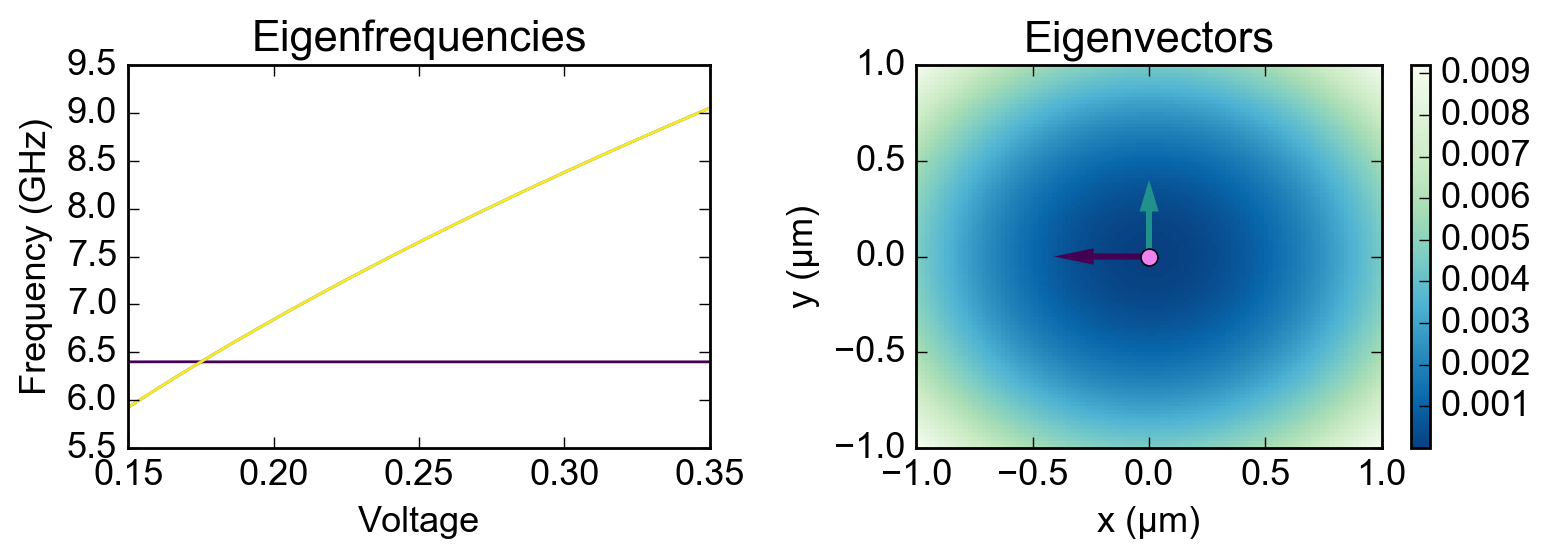

In [71]:
idx = common.find_nearest(Vs, V_crossing)
colors = [plt.cm.viridis(x) for x in np.linspace(0, 1, 3)]

fig = plt.figure(figsize=(8.,3.))

plt.subplot(121)
for n in range(1 + 2):
    plt.plot(Vs, Efreqs[:, n] / 1E9, color=colors[n])
plt.ylabel("Frequency (GHz)")
plt.xlabel("Voltage")
plt.xlim(np.min(Vs), np.max(Vs))
plt.title("Eigenfrequencies")

plt.subplot(122)
plt.pcolormesh(X * 1E6, Y * 1E6, Potential(X, Y, Vs[idx]), cmap=plt.cm.GnBu_r)

for n in range(2):
    plt.plot(0 * 1E6, 0 * 1E6, 'o', color='violet', alpha=1.0)
    plt.arrow(x=0, y=0, dx=0.25*Evecs[idx, 1, 1+n], dy=0.25*Evecs[idx, 2, 1+n], head_width=0.05, head_length=0.10, 
              fc=colors[n], ec=colors[n], lw=2)

plt.xlim(np.min(x) * 1E6, np.max(x) * 1E6)
plt.ylim(np.min(y) * 1E6, np.max(y) * 1E6)
plt.xlabel("x (%sm)"%(chr(956)))
plt.ylabel("y (%sm)"%(chr(956)))
plt.colorbar()
plt.title("Eigenvectors")

fig.tight_layout()

## $N_e = 2$

In [74]:
M = np.diag(np.array([L] + [m_e] * 4))
K = np.zeros((5, 5))

K[0, 0] = 1 / C
K[0, 1:] = qe / C * np.array([Ex, Ex, Ey, Ey])
K[1:, 0] = qe / C * np.array([Ex, Ex, Ey, Ey])

Efreqs = list()
Evecs = list()

for V in tqdm(Vs):

    K[1:, 1:] = np.array([[3 * qe * k * V, -qe * k * V, 0, 0], 
                          [-qe * k * V, 3 * qe * k * V, 0, 0], 
                          [0, 0, 3/2. * qe * k * V, -1/2. * qe * k * V], 
                          [0, 0, -1/2. * qe * k * V, 3/2. * qe * k * V]])

    EVals, EVecs = np.linalg.eig(np.dot(np.linalg.inv(M), K))
    
    Efreqs.append(np.sqrt(EVals) / (2 * np.pi))
    Evecs.append(EVecs)

if 0:
    fig = plt.figure(figsize=(8.,3.))
    common.configure_axes(13)
    plt.subplot(131)
    im = plt.imshow(np.log10(np.abs(K)), interpolation='none', origin='upper')
    plt.title("$\mathcal{K}$")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.subplot(132)
    im = plt.imshow(np.log10(np.abs(M)), interpolation='none', origin='upper')
    plt.title("$\mathcal{M}$")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.subplot(133)
    im = plt.imshow(np.log10(np.abs(np.dot(np.linalg.inv(M), K))), interpolation='none', origin='upper')
    plt.title("$\mathcal{M}^{-1} \mathcal{K}$")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    fig.tight_layout()

Efreqs = np.array(Efreqs)
Evecs = np.array(Evecs)

100%|██████████| 1000/1000 [00:00<00:00, 10866.61it/s]


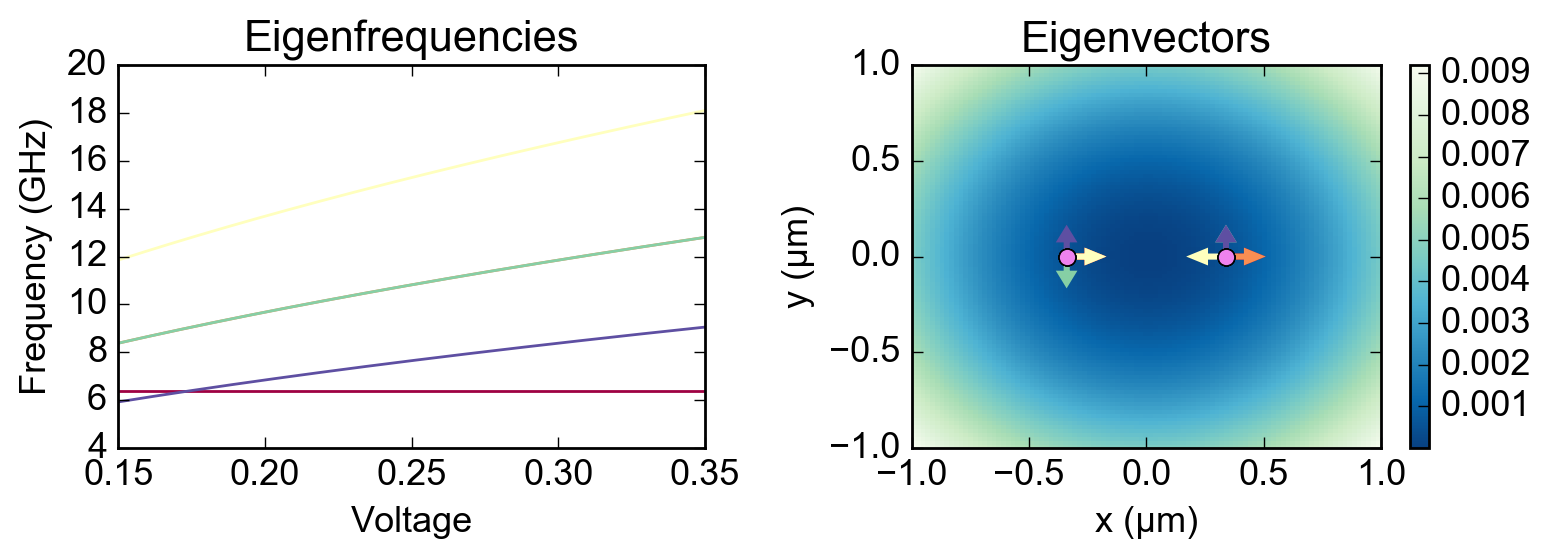

In [75]:
colors = [plt.cm.Spectral(x) for x in np.linspace(0, 1, 5)]

fig = plt.figure(figsize=(8.,3.))

plt.subplot(121)
for n in range(1 + 4):
    plt.plot(Vs, Efreqs[:, n] / 1E9, color=colors[n])
plt.ylabel("Frequency (GHz)")
plt.xlabel("Voltage")
plt.xlim(np.min(Vs), np.max(Vs))
plt.title("Eigenfrequencies")

plt.subplot(122)
plt.pcolormesh(X * 1E6, Y * 1E6, Potential(X, Y, Vs[idx]), cmap=plt.cm.GnBu_r)

r2 = (qe / (2 * np.pi * 8.85E-12 * k * Vs[idx])) ** (1/3.)

for n in range(5):
    plt.plot(r2/2. * 1E6, 0 * 1E6, 'o', color='violet', alpha=1.0)
    plt.plot(-r2/2. * 1E6, 0 * 1E6, 'o', color='violet', alpha=1.0)
    plt.arrow(x=r2/2. * 1E6, y=0, dx=0.25 * Evecs[idx, 1, n]/2., dy=0.25 * Evecs[idx, 1+2, n]/2., 
              head_width=0.05, head_length=0.05, 
              fc=colors[n], ec=colors[n], lw=2)
    plt.arrow(x=-r2/2. * 1E6, y=0, dx=0.25 * Evecs[idx, 2, n]/2., dy=0.25 * Evecs[idx, 2+2, n]/2., 
              head_width=0.05, head_length=0.05, 
              fc=colors[n], ec=colors[n], lw=2)

plt.xlim(np.min(x) * 1E6, np.max(x) * 1E6)
plt.ylim(np.min(y) * 1E6, np.max(y) * 1E6)
plt.xlabel("x (%sm)"%(chr(956)))
plt.ylabel("y (%sm)"%(chr(956)))
plt.colorbar()
plt.title("Eigenvectors")

fig.tight_layout()

# Include an $y^4$ term in the potential

In [162]:
from TrapAnalysis.solve_eom import FullSolver
from scipy.constants import elementary_charge as q_e, electron_mass as m_e

settings_file = r"/Users/gkoolstra/Desktop"
settings_file += r"/With L3 etch - just trap/settings.json"
fs = FullSolver(settings_file)

# Set up the RF electric field path and load it into memory
fs.resonator_constants['f0'] = 6.405E9
fs.resonator_constants['Q'] = 1.3E4
fs.resonator_constants['Z0'] = 90.0

def Ex(xi, yi):
    return 1e1 * np.ones(len(xi))

def Ey(xi, yi):
    return 3E5 * np.exp(-yi ** 2 / (2 * (0.5E-6) ** 2))

fs.Ex = Ex
fs.Ey = Ey

kappa_tot = fs.resonator_constants['f0'] / fs.resonator_constants['Q']

In [165]:
fs.include_screening

1

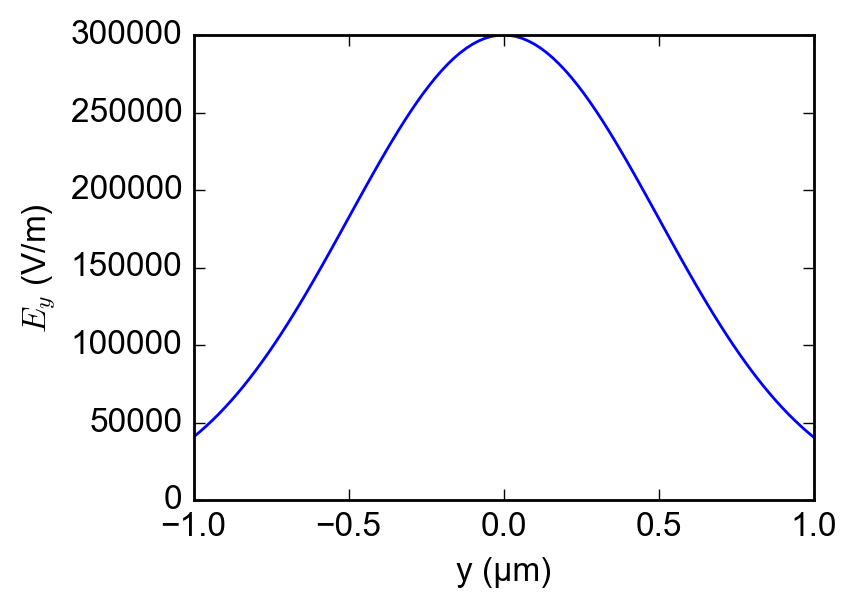

In [166]:
yplot = np.linspace(-1E-6, 1E-6, 101)

plt.figure(figsize=(4.,3.))
common.configure_axes(12)
plt.plot(yplot * 1E6, Ey(np.zeros(len(yplot)), yplot))
plt.xlabel("y (%sm)"%chr(956))
plt.ylabel("$E_y$ (V/m)")

In [167]:
initial_guesses = [{"N" : 1, "init_guess" : np.array([0, 0]), 
                    "adaptive_guess" : True}, 
                   {"N" : 2, "init_guess" : np.array([0.0, 3.34106244e-07, 0.0, -3.34106244e-07]), 
                    "adaptive_guess" : True},
                   {"N" : 3, "init_guess" : np.array([1.88584116e-11, 4.83470160e-07, -2.48886397e-11, 
                                                      -4.83471271e-07, 1.75130320e-11, 7.89948645e-12]), 
                    "adaptive_guess" : True}, 
                   {"N" : 4, "init_guess" : np.array([2.40087325e-07, -7.35031356e-12, -2.40087325e-07, 
                                                      -7.35031356e-12, 0, 5.20539644e-07, 0, -5.20536454e-07]), 
                    "adaptive_guess" : True}]

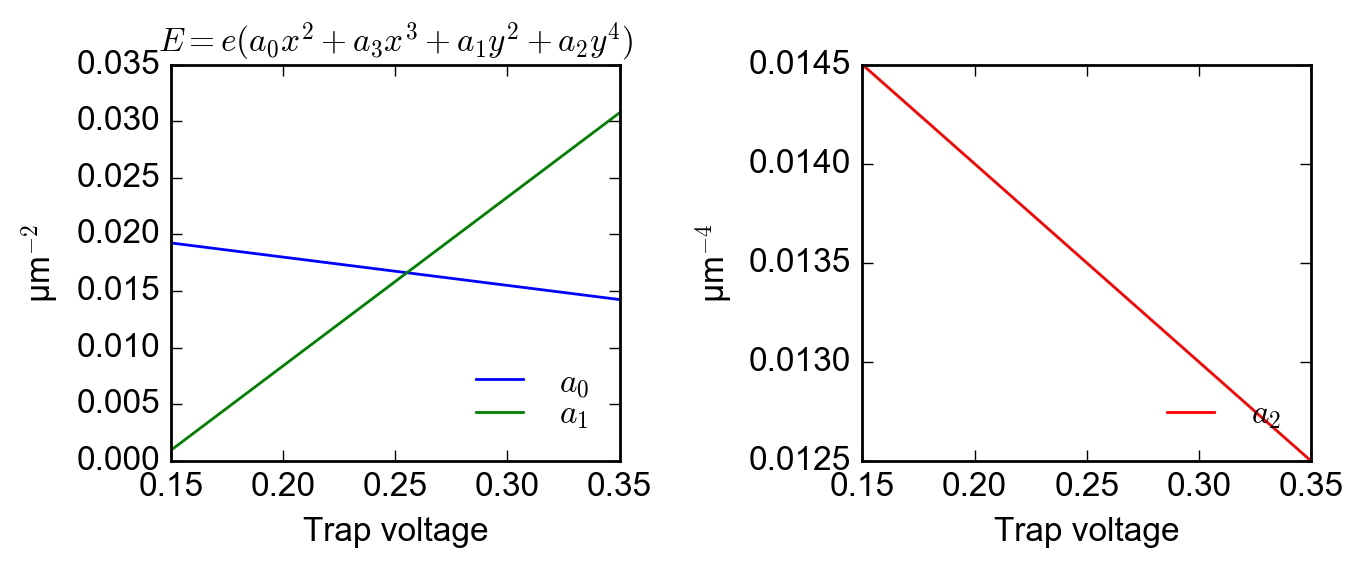

In [198]:
dfdV = 90E9
V_crossing = 0.174

V0 = V_crossing - fs.resonator_constants['f0'] / (2 * dfdV)

Vtrap = np.linspace(0.15, 0.35, 101)
Vrg = np.linspace(-0.415, -0.426, len(Vtrap))
Vres = 0.60 * np.ones(len(Vtrap)) 
Vtg = 0.00 * np.ones(len(Vtrap))

# a_0s = 0.021E12 - 0.02E12 * (Vtrap - V0)
# a_1s = m_e / (2 * q_e) * 8 * np.pi ** 2 * dfdV * fs.resonator_constants['f0'] * (Vtrap - V0)

a_0s = 1E12 * (0.023 - 0.025 * Vtrap) #1E12 * (0.032 - 0.006 - 0.020 * Vtrap)
a_1s = 1E12 * (-0.0214 + 0.149 * Vtrap)

# a_2s = +0.012e24 + 0.05E24 * (Vtrap - V0) #0 * Vtrap
a_2s = 1E24 * (0.016 - 0.01 * Vtrap)
a_3s = 0*0.8 * -1E16 * np.ones(len(Vtrap))

contain_xs = 0*0.001E24 * np.ones(len(Vtrap))

fig = plt.figure(figsize=(7.,3.))
common.configure_axes(12)
plt.subplot(121)
plt.title("$E = e (a_0 x^2 + a_3 x^3 + a_1 y^2 + a_2 y^4)$", size=12)
plt.plot(Vtrap, a_0s * 1E-12, label="$a_0$")
plt.plot(Vtrap, a_1s * 1E-12, label='$a_1$')
plt.xlim(np.min(Vtrap), np.max(Vtrap))
plt.xlabel("Trap voltage")
plt.ylabel("%sm$^{-2}$"%(chr(956)))
plt.legend(loc=4, prop={"size" : 12}, frameon=False)

plt.subplot(122)
plt.plot(Vtrap, a_2s * 1E-24, label='$a_2$', color='r')
# plt.plot(Vtrap, a_3s * 1E-24, label='$a_3$', color='c')
plt.xlim(np.min(Vtrap), np.max(Vtrap))
plt.xlabel("Trap voltage")
plt.ylabel("%sm$^{-4}$"%(chr(956)))
plt.legend(loc=4, prop={"size" : 12}, frameon=False)

fig.tight_layout()

In [199]:
datapath = r"/Volumes/slab/Gerwin/Electron on helium/Papers/2017 - Circuit QED with a single electron on helium/Figure 3"
filename = r"exported_traces_mag_n_phase.h5"

with h5py.File(os.path.join(datapath, filename), 'r') as hf:
    Vtrap_experiment = hf['Vtrap'][:]
    Vrg_experiment = hf['Vrg'][:]
    
    mags_experiment_0 = hf['mags_averaged_normalized_Ne_0'][:]
    mags_experiment_1 = hf['mags_averaged_normalized_Ne_1'][:]
    mags_experiment_2 = hf['mags_averaged_normalized_Ne_2'][:]
    mags_experiment_3 = hf['mags_averaged_normalized_Ne_3'][:]
    mags_experiment_4 = hf['mags_averaged_normalized_Ne_4'][:]
    
    phases_experiment_0 = hf['phase_averaged_Ne_0'][:]
    phases_experiment_1 = hf['phase_averaged_Ne_1'][:]
    phases_experiment_2 = hf['phase_averaged_Ne_2'][:]
    phases_experiment_3 = hf['phase_averaged_Ne_3'][:]
    phases_experiment_4 = hf['phase_averaged_Ne_4'][:]
    
phase_offsets = [0, -0.5, -1, -1.5]

101it [00:07, 14.17it/s]
100%|██████████| 101/101 [00:00<00:00, 52467.76it/s]
101it [00:08, 12.58it/s]
100%|██████████| 101/101 [00:00<00:00, 59800.21it/s]
101it [00:09, 11.08it/s]
100%|██████████| 101/101 [00:00<00:00, 58861.29it/s]
101it [00:13,  9.85it/s]
100%|██████████| 101/101 [00:00<00:00, 40306.82it/s]


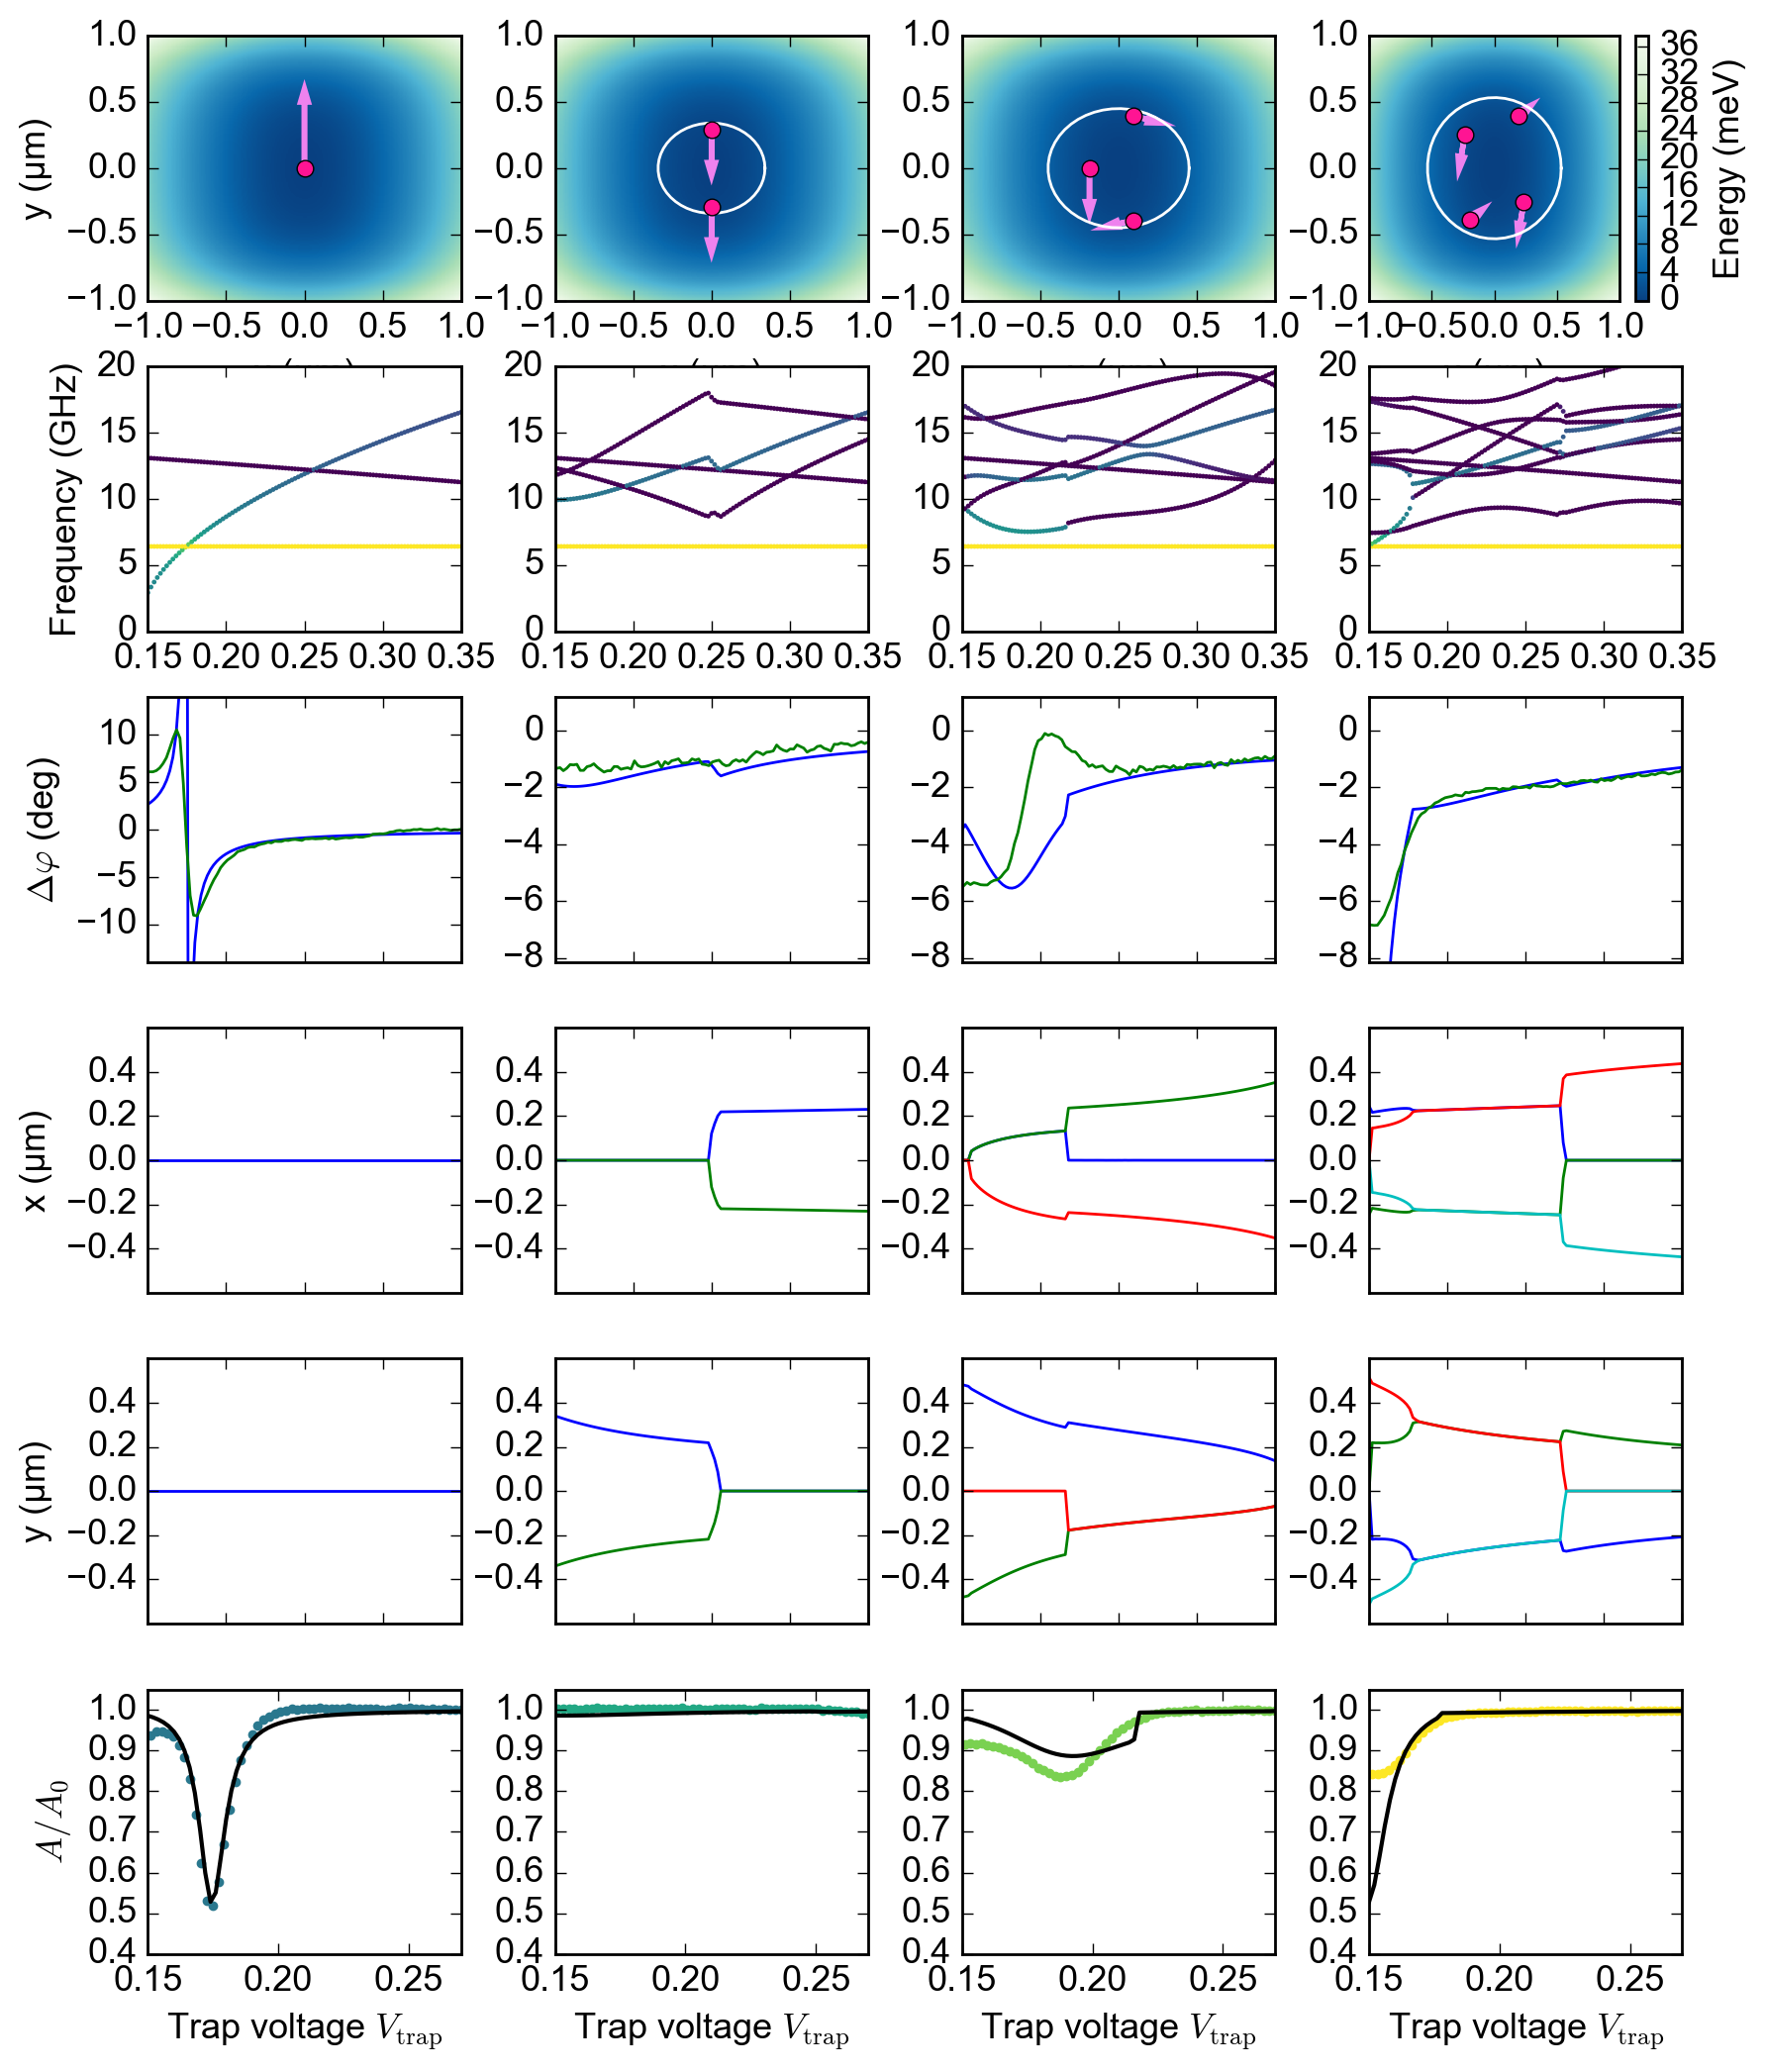

In [200]:
fs.trap_annealing_steps = [0.5] * 10
solve_equations_of_motion = 1

fig2 = plt.figure(figsize=(10, 5*2.5))
common.configure_axes(10)

colors = [plt.cm.viridis(frac) for frac in [0.2, 0.4, 0.6, 0.8, 1.0]]

from TrapAnalysis import single_electron as se

for N in [1, 2, 3, 4]:
    color = colors[::-1][4 - N]
    use_adaptive_initial_guess = initial_guesses[N-1]["adaptive_guess"]
    electron_initial_positions = initial_guesses[N-1]["init_guess"]

    electrons_in_the_trap = list()
    electron_positions = list(); energies = list()
    EVecs = list(); EVals = list()

    Second_Derivs = np.zeros((len(Vtrap), N, 3))

    for k, potential_coeffs in tqdm(enumerate(zip(a_0s, a_1s, a_2s, a_3s, contain_xs))):
        a_0, a_1, a_2, a_3, contain_x = potential_coeffs

        def Phi(xi, yi):
            return a_0 * xi ** 2 + a_3 * xi ** 3  + contain_x * xi ** 4 + a_1 * yi ** 2 + a_2 * yi ** 4

        def Phi_x(xi, yi):
            return 2 * a_0 * xi + 3 * a_3 * xi ** 2 + 4 * contain_x * xi ** 3

        def Phi_y(xi, yi):
            return 2 * a_1 * yi + 4 * a_2 * yi ** 3

        def Phi_xx(xi, yi):
            return 2 * a_0 * np.ones(len(xi)) + 6 * a_3 * xi + 12 * contain_x * xi ** 2

        def Phi_xy(xi, yi):
            return np.zeros(len(xi))

        def Phi_yy(xi, yi):
            return 2 * a_1 * np.ones(len(xi)) + 12 * a_2 * yi ** 2

        dummy_x = np.linspace(-2E-6, 2E-6, 501)
        dummy_y = np.linspace(-2E-6, 2E-6, 501)

        CMS = anneal.TrapAreaSolver(dummy_x, dummy_y, np.meshgrid(dummy_x, dummy_y)[0],
                                    spline_order_x=3, spline_order_y=3, smoothing=0,
                                    include_screening=fs.include_screening, screening_length=fs.screening_length)
        CMS.V = Phi

        CMS.dVdx = Phi_x
        CMS.dVdy = Phi_y

        fs.curv_xx = Phi_xx
        fs.curv_xy = Phi_xy
        fs.curv_yy = Phi_yy

        X_eval, Y_eval = np.meshgrid(dummy_x, dummy_y)

        # Solve for the electron positions in the trap area!
        ConvMon = anneal.ConvergenceMonitor(Uopt=CMS.Vtotal, grad_Uopt=CMS.grad_total, N=1,
                                            Uext=CMS.V,
                                            xext=dummy_x, yext=dummy_y, verbose=False, eps=fs.epsilon,
                                            save_path=None)

        ConvMon.figsize = (8., 2.)

        trap_minimizer_options = {'method': 'L-BFGS-B',
                                  'jac': CMS.grad_total,
                                  'options': {'disp': False, 'gtol': fs.gradient_tolerance, 'eps': fs.epsilon},
                                  'callback': None}

        # We save the initial Jacobian of the system for purposes.
        initial_jacobian = CMS.grad_total(electron_initial_positions)
        res = minimize(CMS.Vtotal, electron_initial_positions, **trap_minimizer_options)

        while res['status'] > 0:
            # Try removing unbounded electrons and restart the minimization
            if fs.remove_unbound_electrons:
                # Remove any electrons that are to the left of the trap
                best_x, best_y = anneal.r2xy(res['x'])
                idxs = np.where(np.logical_and(best_x > fs.remove_bounds[0], best_x < fs.remove_bounds[1]))[0]
                best_x = np.delete(best_x, idxs)
                best_y = np.delete(best_y, idxs)
                # Use the solution from the current time step as the initial condition for the next timestep!
                electron_initial_positions = anneal.xy2r(best_x, best_y)
                if len(best_x) < len(res['x'][::2]):
                    print("%d/%d unbounded electrons removed. %d electrons remain." % (
                    np.int(len(res['x'][::2]) - len(best_x)), len(res['x'][::2]), len(best_x)))
                res = minimize(CMS.Vtotal, electron_initial_positions, **trap_minimizer_options)
            else:
                best_x, best_y = anneal.r2xy(res['x'])
                idxs = np.union1d(np.where(best_x < -2E-6)[0], np.where(np.abs(best_y) > 2E-6)[0])
                if len(idxs) > 0:
                    print("Following electrons are outside the simulation domain")
                    for i in idxs:
                        print("(x,y) = (%.3f, %.3f) um" % (best_x[i] * 1E6, best_y[i] * 1E6))
                # To skip the infinite while loop.
                break

        if res['status'] > 0:
            cprint("WARNING: Initial minimization for Trap did not converge!", "red")
            print("Final L-inf norm of gradient = %.2f eV/m" % (np.amax(res['jac'])))
            best_res = res
            if k == 0:
                cprint("Please check your initial condition, are all electrons confined in the simulation area?", "red")
                break

        if len(fs.trap_annealing_steps) > 0:
            # cprint("SUCCESS: Initial minimization for Trap converged!", "green")
            best_res = CMS.perturb_and_solve(CMS.Vtotal, len(fs.trap_annealing_steps), fs.trap_annealing_steps[0],
                                             res, maximum_dx=fs.max_x_displacement, maximum_dy=fs.max_y_displacement,
                                             do_print=False, **trap_minimizer_options)
        else:
            best_res = res

        # Use the solution from the current time step as the initial condition for the next timestep!
        if use_adaptive_initial_guess:
            electron_initial_positions = best_res['x']
        ex, ey = anneal.r2xy(best_res['x'])
        electrons_in_the_trap.append(np.sum(np.logical_and(ex < 1.5E-6,
                                                           ex > 1.5E-6)))

        electron_positions.append(res['x'])
        energies.append(res['fun']) # this will contain the total minimized energy in eV

        if solve_equations_of_motion:
            LHS, RHS = fs.setup_eom(best_res['x'])
            evals, evecs = fs.solve_eom(LHS, RHS)
            EVals.append(evals)
            EVecs.append(evecs)

            Second_Derivs[k, :, 0] = fs.curv_xx(ex, ey)
            Second_Derivs[k, :, 1] = fs.curv_xy(ex, ey)
            Second_Derivs[k, :, 2] = fs.curv_yy(ex, ey)
 
    electron_positions = np.array(electron_positions)
    energies = np.array(energies)
    EVecs = np.array(EVecs)
    EVals = np.array(EVals)
    Efreqs = np.sqrt(EVals) / (2 * np.pi)

    # Plot the resonator and trap electron configuration at the voltage given by idx
    idx = common.find_nearest(Vtrap, V_crossing)
    trap_electrons_x, trap_electrons_y = anneal.r2xy(electron_positions[idx, :])
    
    a_0, a_1, a_2, a_3, contain_x = a_0s[idx], a_1s[idx], a_2s[idx], a_3s[idx], contain_xs[idx]
    def Phi(xi, yi):
            return a_0 * xi ** 2 + a_3 * xi ** 3  + contain_x * xi ** 4 + a_1 * yi ** 2 + a_2 * yi ** 4
    
    plt.subplot(6, 4, N)
    common.configure_axes(13)
    plt.pcolormesh(dummy_x * 1E6, dummy_y * 1E6, Phi(X_eval, Y_eval) * 1E3, cmap=plt.cm.GnBu_r, 
                   vmin=0, vmax=1E3 * Phi(1.0E-6, 1.0E-6))
    
    # If a_0 == a_1 (radially symmetric) and a_2 = 0, electrons should be on this ring
    theta = np.linspace(0, 2 * np.pi)
    r0 = (2 * q_e ** 2 / (m_e * 4 * np.pi * 8.85E-12 * 2 * q_e * a_1 / m_e)) ** (1 / 3.)
    
    if N == 2: 
        plt.plot(0.5 * r0 * np.cos(theta) * 1E6, 0.5 * r0 * np.sin(theta) * 1E6, color='white')
    if N == 3: 
        plt.plot(0.66 * r0 * np.cos(theta) * 1E6, 0.66 * r0 * np.sin(theta) * 1E6, color='white')
    if N == 4: 
        plt.plot(0.782 * r0 * np.cos(theta) * 1E6, 0.782 * r0 * np.sin(theta) * 1E6, color='white')

    if best_res['status'] > 0:
        plt.text(0, -2, "Minimization did not converge", fontdict={"size": 10})

    plt.xlabel("x (%sm)"%(chr(956)))
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    plt.plot(trap_electrons_x * 1E6, trap_electrons_y * 1E6, 'o', color='deeppink', alpha=1.0)
    if N == 4:
        cbar = plt.colorbar()
        cbar.ax.set_ylabel("Energy (meV)")
    elif N == 1:
        plt.ylabel("y (%sm)"%(chr(956)))
        
    plt.subplot(6, 4, N + 4)
        
    for i in range(len(Vtrap)):
        sc = plt.scatter([Vtrap[i]]*(2*N + 1), np.sqrt(EVals)[i, :] / (2 * np.pi * 1E9), 
                         c=np.log10(np.abs(EVecs[i, 0, :])), edgecolors='none', cmap=plt.cm.viridis,
                         vmin=0, vmax=4, s=3)


    plt.xlim(np.min(Vtrap), np.max(Vtrap))
    plt.ylim(0, 20)

    if N == 1:
        plt.ylabel('Frequency (GHz)')
    
    all_ordered_freqs = list()
    strongest_coupled_evecs = list()
    for jj in trange(np.shape(EVecs)[0]):
        cavity_contributions = EVecs[jj, 0, :]
        largest_cavity_contributions = np.argsort(np.abs(cavity_contributions))[::-1]
        all_ordered_freqs.append(np.sqrt(EVals[jj, largest_cavity_contributions])/(2*np.pi*1E9))
        strongest_coupled_evecs.append(EVecs[jj, :, largest_cavity_contributions[1]])
        
        if jj == idx:
            # Mode #0 is the cavity mode (not interesting)
            mode_nr_1 = largest_cavity_contributions[1]
            # Plot the eigenvectors
    
    amp = EVecs[idx, 1:, mode_nr_1] / np.sum(np.abs(EVecs[idx, 1:, mode_nr_1])) * 0.5
    plt.subplot(6, 4, N)
    for m in range(N):
        plt.arrow(x=electron_positions[idx, ::2][m] * 1E6, y=electron_positions[idx, 1::2][m] * 1E6, dx=amp[m], 
                  dy=amp[N+m] * 1, head_width=0.05, head_length=0.10, fc='violet', ec='violet', lw=2)

    all_ordered_freqs = np.array(all_ordered_freqs)
    strongest_coupled_evecs = np.array(strongest_coupled_evecs)
    
    # Calculate the coupling
    if N == 1:
        g_test = common.find_nearest(Vtrap, 0.20)
        all_ordered_freqs[g_test, 0]
        cav_freq_shift = np.abs(all_ordered_freqs[g_test, 0] * 1E9 - fs.resonator_constants['f0'])
        detuning = np.abs(all_ordered_freqs[g_test, 0] - all_ordered_freqs[g_test, 1]) * 1E9

#         print("The average coupling from the EOM is g = ", 1E-6 * np.sqrt(cav_freq_shift * detuning / N), " MHz")
    
    plt.subplot(6, 4, N + 4 + 4)
    plt.plot(Vtrap, 180. / (np.pi * kappa_tot) * (all_ordered_freqs[:, 0] * 1E9 - fs.resonator_constants['f0']))
    plt.xlim(np.min(Vtrap), np.max(Vtrap))
    plt.gca().set_xticklabels([])
    
    try: 
        plt.plot(Vtrap_experiment, vars()['phases_experiment_%d'%N] + phase_offsets[N-1])
    except:
        pass
    
    if N == 1:
#         plt.ylabel(r'$\Delta f_0$ (MHz)')
        plt.ylabel(r'$\Delta \varphi$ (deg)')
        plt.ylim(-0.12E6 * 180/(np.pi * kappa_tot), 0.12E6 * 180/(np.pi * kappa_tot))
    else:
        plt.ylim(-0.07E6 * 180/(np.pi * kappa_tot), 0.01E6 * 180/(np.pi * kappa_tot))
        
    plt.subplot(6, 4, N + 3 * 4)
    for n in range(N):
        plt.plot(Vtrap, electron_positions[:, 2*n] * 1E6)
    plt.xlim(np.min(Vtrap), np.max(Vtrap))
    plt.ylim(-0.6, 0.6)
    plt.gca().set_xticklabels([])
    
    if N == 1:
        plt.ylabel('x (%sm)'%(chr(956)))
        
    plt.subplot(6, 4, N + 4 * 4)
    for n in range(N):
        plt.plot(Vtrap, electron_positions[:, 1 + 2*n] * 1E6)
    plt.xlim(np.min(Vtrap), np.max(Vtrap))
    plt.ylim(-0.6, 0.6)
    plt.gca().set_xticklabels([])
    
    if N == 1:
        plt.ylabel('y (%sm)'%(chr(956)))
        
    electron_modes_to_consider = [1] #[1, 2, 3, 4] # Note: 0 is the cavity mode
    kappa_tot = fs.resonator_constants['f0'] / fs.resonator_constants['Q']
    f_probe = fs.resonator_constants['f0']
    f_cavity = fs.resonator_constants['f0']
    
    # mag_signal, phase_signal = list(), list()
    chi = np.zeros(len(Vtrap), dtype=np.complex128)
    for i, g in enumerate(Vtrap):
        for mode in electron_modes_to_consider:
            chi[i] += se.susceptibility(6.5E6, f_probe, all_ordered_freqs[i, mode] * 1E9, 450E6)

    single_response = 2 * np.pi * (kappa_tot / 2.) / (2 * np.pi * (f_probe - f_cavity) - chi + 1j * 2 * np.pi * (kappa_tot / 2.))
    mag_signal = 20 * np.log10(np.abs(single_response))
    phase_signal = 180/np.pi * (np.arctan2(-np.imag(single_response), np.real(single_response)) - np.pi/2.)    

    plt.subplot(6, 4, N + 5 * 4)
    try: 
        plt.plot(Vtrap_experiment, vars()['mags_experiment_%d'%N], '.', color=color, lw=2, label='Experiment')
    except:
        pass
    plt.plot(Vtrap, 10 ** (mag_signal / 10.), '-', color='k', ms=2, lw=1.5, label='Model')
    plt.ylim(0.40, 1.05)
    plt.xlim(np.min(Vtrap), 0.27)
    plt.xticks([0.15, 0.20, 0.25])
    if N == 1:
        plt.ylabel("$A/A_0$")
        
    plt.xlabel('Trap voltage $V_\mathrm{trap}$')
    
    vars()["Positions_%d"%N] = electron_positions
    vars()["Simulated_Magnitude_%d"%N] = 10 ** (mag_signal / 10.)
    vars()["Simulated_Phase_%d"%N] = phase_signal
    vars()["All_Frequencies_%d"%N] = all_ordered_freqs
    vars()["All_Eigenvectors_%d"%N] = strongest_coupled_evecs
    
plt.subplots_adjust(wspace=0.30, hspace=0.25)
# fig2.tight_layout()

(-2, 2)

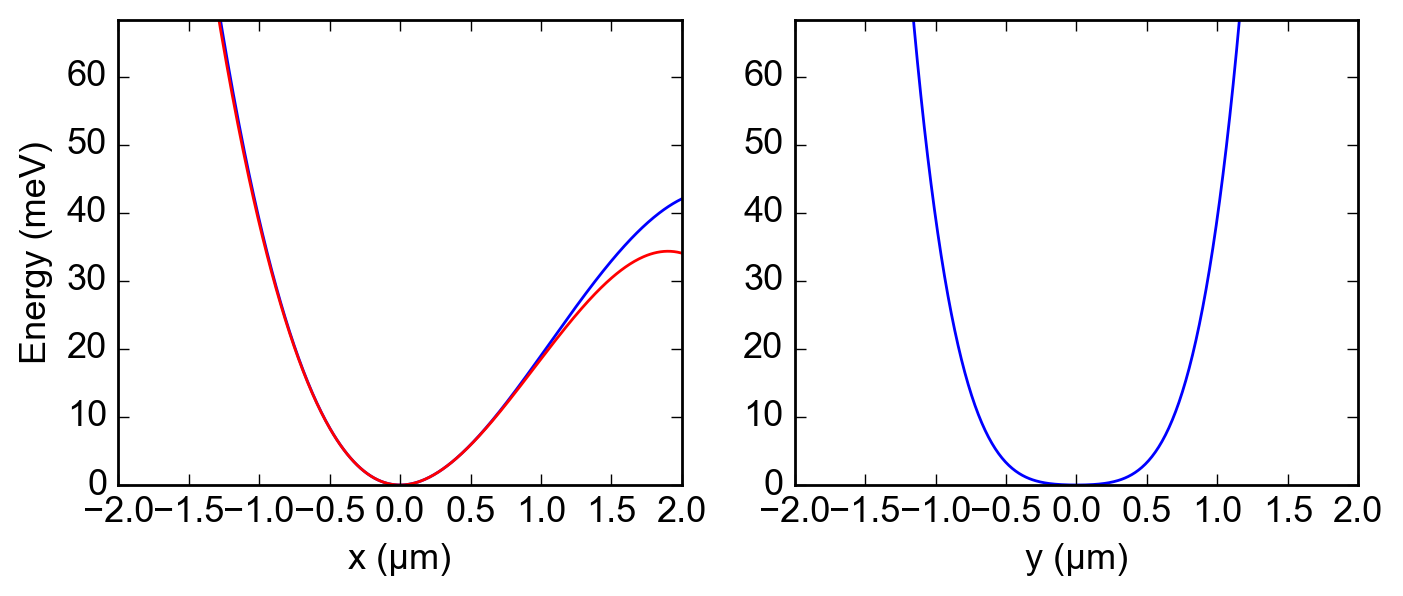

In [95]:
plt.figure(figsize=(8.,3.))
plt.subplot(121)
plt.plot(dummy_x * 1E6, (Phi(dummy_x, 0)) * 1E3)
plt.plot(dummy_x * 1E6, (Phi(dummy_x, 0) - contain_x * dummy_x ** 4) * 1E3, 'r')
plt.xlabel("x (%sm)"%(chr(956)))
plt.ylabel("Energy (meV)")
plt.ylim(0, 10 + Phi(1E-6, 1E-6) * 1E3)
plt.xlim(-2, 2)

plt.subplot(122)
plt.plot(dummy_y * 1E6, Phi(0, dummy_y) * 1E3)
plt.xlabel("y (%sm)"%(chr(956)))
plt.ylim(0, 10 + Phi(1E-6, 1E-6) * 1E3)
plt.xlim(-2, 2)

In [201]:
datapath = r"/Volumes/slab/Gerwin/Electron on helium/Papers/2017 - Circuit QED with a single electron on helium/Figure 3"
filename = r"simulation_data.h5"

if 1:
    with h5py.File(os.path.join(datapath, filename), 'w') as hf:
        hf.create_dataset("Vtrap", data=Vtrap)
        hf.create_dataset("Vrg", data=Vrg)
        
        hf.create_dataset("Positions_1", data=Positions_1)
        hf.create_dataset("Positions_2", data=Positions_2)
        hf.create_dataset("Positions_3", data=Positions_3)
        hf.create_dataset("Positions_4", data=Positions_4)
        
        hf.create_dataset("Potential_a0", data=a_0s)
        hf.create_dataset("Potential_a1", data=a_1s)
        hf.create_dataset("Potential_a2", data=a_2s)
        hf.create_dataset("Potential_a3", data=a_3s)
        
        hf.create_dataset("Potential_X", data=X_eval)
        hf.create_dataset("Potential_Y", data=Y_eval)
        hf.create_dataset("Potential_mV", data=Phi(X_eval, Y_eval) * 1E3)

        hf.create_dataset("Simulated_Magnitude_1", data=Simulated_Magnitude_1)
        hf.create_dataset("Simulated_Magnitude_2", data=Simulated_Magnitude_2)
        hf.create_dataset("Simulated_Magnitude_3", data=Simulated_Magnitude_3)
        hf.create_dataset("Simulated_Magnitude_4", data=Simulated_Magnitude_4)
        
        hf.create_dataset("Simulated_Phase_1", data=Simulated_Phase_1)
        hf.create_dataset("Simulated_Phase_2", data=Simulated_Phase_2)
        hf.create_dataset("Simulated_Phase_3", data=Simulated_Phase_3)
        hf.create_dataset("Simulated_Phase_4", data=Simulated_Phase_4)
        
        hf.create_dataset("All_Frequencies_4", data=All_Frequencies_4)
        hf.create_dataset("All_Frequencies_3", data=All_Frequencies_3)
        hf.create_dataset("All_Frequencies_2", data=All_Frequencies_2)
        hf.create_dataset("All_Frequencies_1", data=All_Frequencies_1)
        
        hf.create_dataset("All_Eigenvectors_4", data=All_Eigenvectors_4)
        hf.create_dataset("All_Eigenvectors_3", data=All_Eigenvectors_3)
        hf.create_dataset("All_Eigenvectors_2", data=All_Eigenvectors_2)
        hf.create_dataset("All_Eigenvectors_1", data=All_Eigenvectors_1)